# 📊 Telco Customer Churn Prediction - Professional Analysis

## Project Objective
Develop a machine learning model to predict customer churn for a telecommunications company, providing actionable insights for customer retention strategies.

## Business Context
- **Problem**: High customer churn rates impact revenue and growth
- **Goal**: Identify at-risk customers and key churn drivers
- **Impact**: Enable proactive retention campaigns and strategic decision-making

## Methodology
End-to-end data science pipeline from data exploration to model deployment and Power BI integration.


In [2]:
# Import essential libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Model evaluation
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                           precision_score, recall_score, f1_score, roc_auc_score,
                           roc_curve, precision_recall_curve)

# Feature importance and interpretation
from sklearn.inspection import permutation_importance
import shap

# Utility libraries
import joblib
import pickle
from datetime import datetime
import os

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✅ All libraries imported successfully!
📅 Analysis Date: 2025-09-14 04:58:09


#Data Loading & Initial Inspection

In [3]:
df = pd.read_csv("/content/Telco-Customer-Churn.csv")

In [4]:
print(f"Dataset Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset Shape: (7043, 21)
Memory Usage: 6.82 MB


In [5]:
# Display first few rows
display(df.head())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
# Display column information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


#Data Quality Assessment

In [8]:
# Missing values analysis
missing_data = df.isnull().sum()
missing_data

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [9]:
# Duplicate detection
duplicates = df.duplicated().sum()
print(f"\n Duplicate Records: {duplicates}")


 Duplicate Records: 0


In [10]:
# Data types summary
print(df.dtypes.value_counts())

object     18
int64       2
float64     1
Name: count, dtype: int64


18 columns are categorical (object) → need encoding before ML.

2 columns are integers (int64) → already numeric.

1 column is float (float64) → already numeric.

In [11]:
# Unique values for categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"\n🏷️ Categorical Variables ({len(categorical_cols)}):")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")


🏷️ Categorical Variables (18):
customerID: 7043 unique values
gender: 2 unique values
Partner: 2 unique values
Dependents: 2 unique values
PhoneService: 2 unique values
MultipleLines: 3 unique values
InternetService: 3 unique values
OnlineSecurity: 3 unique values
OnlineBackup: 3 unique values
DeviceProtection: 3 unique values
TechSupport: 3 unique values
StreamingTV: 3 unique values
StreamingMovies: 3 unique values
Contract: 3 unique values
PaperlessBilling: 2 unique values
PaymentMethod: 4 unique values
TotalCharges: 6531 unique values
Churn: 2 unique values


# Target Variable Analysis

In [12]:
# Churn distribution
churn_counts = df['Churn'].value_counts()
churn_percentage = df['Churn'].value_counts(normalize=True) * 100

print("Churn Distribution:")
for value, count, pct in zip(churn_counts.index, churn_counts.values, churn_percentage.values):
    print(f"{value}: {count} ({pct:.1f}%)")


Churn Distribution:
No: 5174 (73.5%)
Yes: 1869 (26.5%)


In [13]:
# Check for class imbalance
imbalance_ratio = churn_counts.min() / churn_counts.max()
print(f"\n Class Imbalance Ratio: {imbalance_ratio:.3f}")



 Class Imbalance Ratio: 0.361


Significant class imbalance detected - consider balancing techniques

#Data Visualization

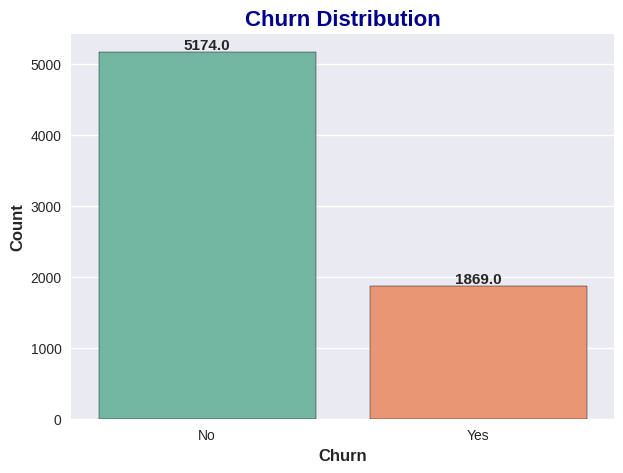

In [14]:
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='Churn', palette='Set2', edgecolor='black')

plt.title('Churn Distribution', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Churn', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.show()


In [15]:
g_labels = ['Male', 'Female']
c_labels = ['No', 'Yes']
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=g_labels, values=df['gender'].value_counts(), name="Gender"),
              1, 1)
fig.add_trace(go.Pie(labels=c_labels, values=df['Churn'].value_counts(), name="Churn"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    title_text="Gender and Churn Distributions",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Gender', x=0.16, y=0.5, font_size=20, showarrow=False),
                 dict(text='Churn', x=0.84, y=0.5, font_size=20, showarrow=False)])
fig.show()

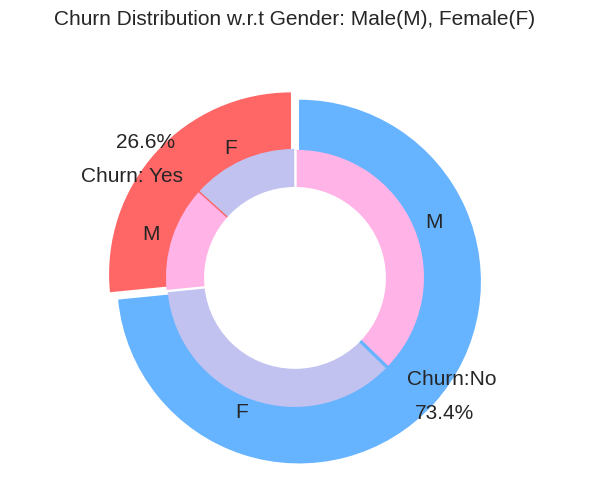

In [16]:
plt.figure(figsize=(6, 5))
labels =["Churn: Yes","Churn:No"]
values = [1869,5163]
labels_gender = ["F","M","F","M"]
sizes_gender = [939,930 , 2544,2619]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
explode = (0.3,0.3)
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Churn Distribution w.r.t Gender: Male(M), Female(F)', fontsize=15, y=1.1)

# show plot

plt.axis('equal')
plt.tight_layout()
plt.show()

In [17]:
fig = px.histogram(df, x="Churn", color="Contract", barmode="group", title="<b>Customer contract distribution<b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [18]:
labels = df['PaymentMethod'].unique()
values = df['PaymentMethod'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title_text="<b>Payment Method Distribution</b>")
fig.show()

In [19]:
fig = px.histogram(df, x="Churn", color="PaymentMethod", title="<b>Customer Payment Method distribution w.r.t. Churn</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [20]:
df["InternetService"].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [21]:
fig = go.Figure()

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ["Female", "Male", "Female", "Male"]],
  y = [965, 992, 219, 240],
  name = 'DSL',
))

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ["Female", "Male", "Female", "Male"]],
  y = [889, 910, 664, 633],
  name = 'Fiber optic',
))

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ["Female", "Male", "Female", "Male"]],
  y = [690, 717, 56, 57],
  name = 'No Internet',
))

fig.update_layout(title_text="<b>Churn Distribution w.r.t. Internet Service and Gender</b>")

fig.show()

In [22]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(df, x="Churn", color="Dependents", barmode="group", title="<b>Dependents distribution</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [23]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(df, x="Churn", color="Partner", barmode="group", title="<b>Chrun distribution w.r.t. Partners</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [24]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(df, x="Churn", color="OnlineSecurity", barmode="group", title="<b>Churn w.r.t Online Security</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [25]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(df, x="Churn", color="PaperlessBilling",  title="<b>Chrun distribution w.r.t. Paperless Billing</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [26]:
fig = px.histogram(df, x="Churn", color="TechSupport",barmode="group",  title="<b>Chrun distribution w.r.t. TechSupport</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [27]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(df, x="Churn", color="PhoneService", title="<b>Chrun distribution w.r.t. Phone Service</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

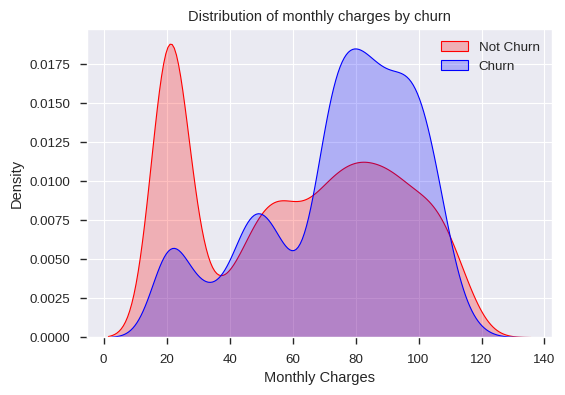

In [28]:
plt.figure(figsize=(6,4))
sns.set_context("paper",font_scale=1.1)
ax = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == "No") ],
                color="Red", shade = True);
ax = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == "Yes") ],
                ax =ax, color="Blue", shade= True);
ax.legend(["Not Churn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Monthly Charges');
ax.set_title('Distribution of monthly charges by churn');


In [29]:
# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Drop rows with missing/NaN TotalCharges if any
df = df.dropna(subset=["TotalCharges"])


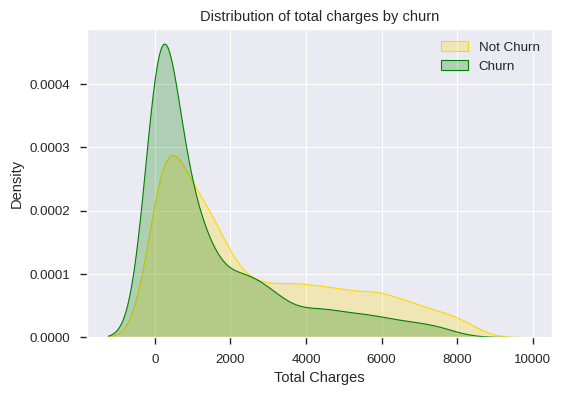

In [30]:
plt.figure(figsize=(6,4))
ax = sns.kdeplot(df.TotalCharges[(df["Churn"] == "No") ],
                color="Gold", shade = True);
ax = sns.kdeplot(df.TotalCharges[(df["Churn"] == "Yes") ],
                ax =ax, color="Green", shade= True);
ax.legend(["Not Churn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Total Charges');
ax.set_title('Distribution of total charges by churn');

In [31]:
# Set a clean theme
sns.set_theme(style="whitegrid", context="talk")

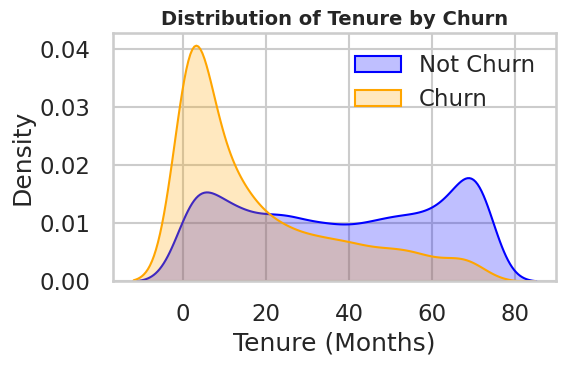

In [32]:
plt.figure(figsize=(6,4))
sns.kdeplot(df.tenure[df["Churn"] == "No"],
            color="blue", fill=True, label="Not Churn")
sns.kdeplot(df.tenure[df["Churn"] == "Yes"],
            color="orange", fill=True, label="Churn")

plt.title("Distribution of Tenure by Churn", fontsize=14, weight="bold")
plt.xlabel("Tenure (Months)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


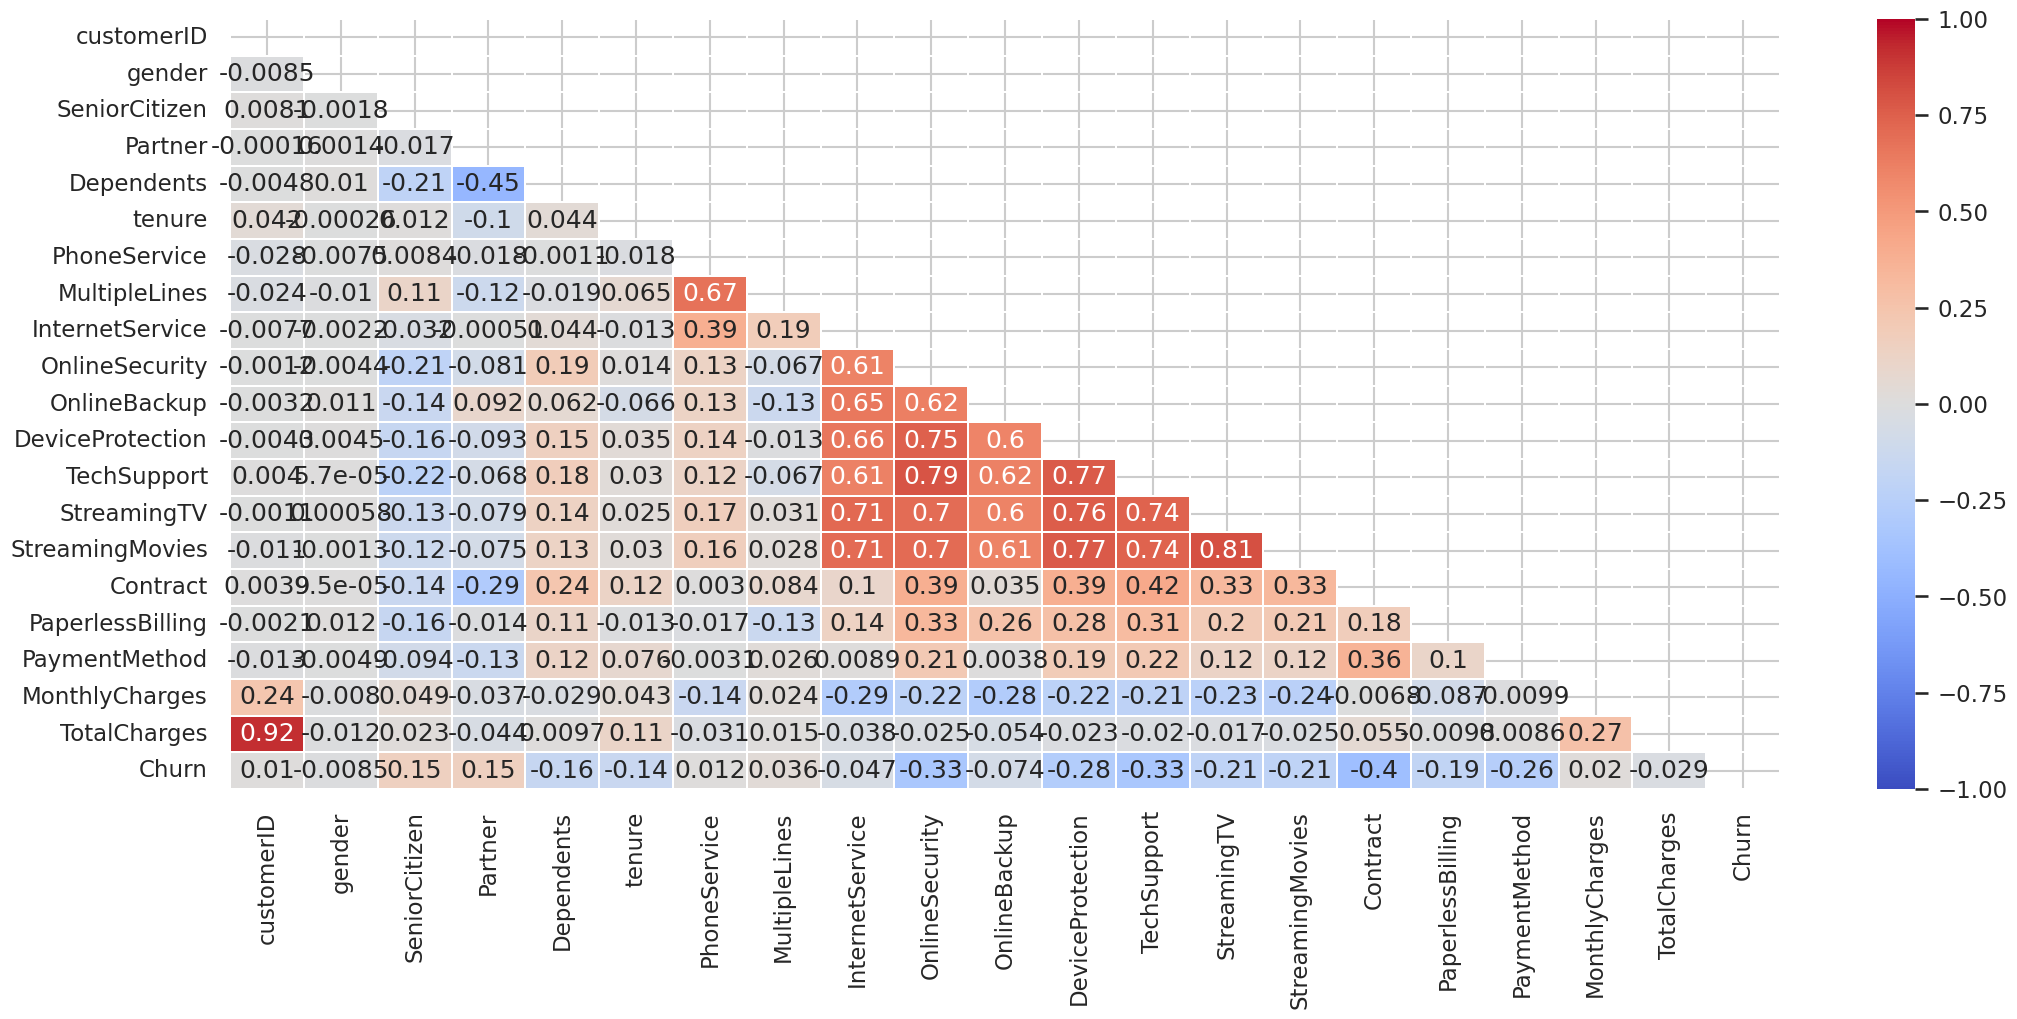

In [33]:
plt.figure(figsize=(25, 10))

corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

In [34]:
fig = px.box(df, x='Churn', y = 'tenure')

# Update yaxis properties
fig.update_yaxes(title_text='Tenure (Months)', row=1, col=1)
# Update xaxis properties
fig.update_xaxes(title_text='Churn', row=1, col=1)

# Update size and title
fig.update_layout(autosize=True, width=750, height=600,
    title_font=dict(size=25, family='Courier'),
    title='<b>Tenure vs Churn</b>',
)

fig.show()


#Data Preprocessing - Missing Values & Data Types

In [35]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Drop customerID (not useful for prediction).

Convert TotalCharges to numeric (it has spaces/strings sometimes).

Encode categorical columns (gender, Partner, Dependents, …).

Scale numeric columns (tenure, MonthlyCharges, TotalCharges).

Handle class imbalance with SMOTE.

In [36]:
# Copy dataframe
df_processed = df.copy()

In [37]:
# 1. Drop customerID
df_processed.drop("customerID", axis=1, inplace=True)

In [38]:
# 3. Encode categorical variables
cat_cols = df_processed.select_dtypes(include=["object"]).columns.tolist()
cat_cols.remove("Churn")
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [39]:
label_enc = LabelEncoder()
for col in cat_cols:
    df_processed[col] = label_enc.fit_transform(df_processed[col])

In [40]:
# Encode target variable (Churn: Yes=1, No=0)
df_processed["Churn"] = df_processed["Churn"].map({"Yes": 1, "No": 0})

In [41]:
# 4. Scale numerical features
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

scaler = StandardScaler()
df_processed[num_cols] = scaler.fit_transform(df_processed[num_cols])

#Train test Split

In [42]:
# 5. Split data into features & target
X = df_processed.drop("Churn", axis=1)
y = df_processed["Churn"]

In [43]:
# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [44]:
print(y_train.value_counts())

Churn
0    4130
1    1495
Name: count, dtype: int64


imbalance is moderate (3:1) -> apply SMOTE

In [45]:
from imblearn.over_sampling import SMOTE


# 7. Apply SMOTE to handle imbalance
smote = SMOTE(random_state=42)
smote

SMOTE(random_state=42)

In [46]:
X_train, y_train = smote.fit_resample(X_train, y_train)


In [47]:
print("\nAfter SMOTE class distribution:")
print(y_train.value_counts())


After SMOTE class distribution:
Churn
0    4130
1    4130
Name: count, dtype: int64


In [48]:
y_train.shape

(8260,)

#Feature Engg

In [49]:
# Make a copy to avoid modifying original
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

In [50]:
# 1. Create tenure groups
def tenure_group(tenure):
    if tenure <= -0.5:  # just in case (scaled tenure before)
        return "Unknown"
    elif tenure <= 1:   # after scaling, ~0 means small tenure
        return "New"
    elif tenure <= 2:
        return "Mid"
    else:
        return "Loyal"


# Note: since tenure was scaled, use raw df for grouping
raw_tenure = df["tenure"]  # keep original before scaling
bins = [0, 12, 24, 48, 72]  # monthly bins
labels = ["0-12", "13-24", "25-48", "49-72"]
df["TenureGroup"] = pd.cut(raw_tenure, bins=bins, labels=labels, include_lowest=True)

In [51]:
# Add TenureGroup back to train/test
X_train_fe["TenureGroup"] = pd.cut(
    (X_train["tenure"] * df["tenure"].std() + df["tenure"].mean()),
    bins=bins, labels=labels, include_lowest=True
)
X_test_fe["TenureGroup"] = pd.cut(
    (X_test["tenure"] * df["tenure"].std() + df["tenure"].mean()),
    bins=bins, labels=labels, include_lowest=True
)

In [52]:
# Encode TenureGroup
tenure_le = LabelEncoder()
X_train_fe["TenureGroup"] = tenure_le.fit_transform(X_train_fe["TenureGroup"].astype(str))
X_test_fe["TenureGroup"] = tenure_le.transform(X_test_fe["TenureGroup"].astype(str))


In [53]:
# 2. Average charges per month
X_train_fe["AvgChargesPerMonth"] = (X_train["TotalCharges"] / (X_train["tenure"] + 1))
X_test_fe["AvgChargesPerMonth"] = (X_test["TotalCharges"] / (X_test["tenure"] + 1))


In [54]:
# 3. Services count
service_cols = [
    "PhoneService", "MultipleLines", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"
]

X_train_fe["ServicesCount"] = X_train[service_cols].sum(axis=1)
X_test_fe["ServicesCount"] = X_test[service_cols].sum(axis=1)


In [55]:
# 4. Contract type ordinal (already encoded but make ordinal mapping)
contract_map = {0: 0, 1: 1, 2: 2}  # Assuming encoding already handled
if "Contract" in X_train.columns:
    X_train_fe["ContractType"] = X_train["Contract"]
    X_test_fe["ContractType"] = X_test["Contract"]

In [56]:
# 5. Payment method simplified (Auto vs Manual)
if "PaymentMethod" in X_train.columns:
    X_train_fe["AutoPayment"] = X_train["PaymentMethod"].apply(lambda x: 1 if x in [0,1] else 0)
    X_test_fe["AutoPayment"] = X_test["PaymentMethod"].apply(lambda x: 1 if x in [0,1] else 0)

In [57]:
print("✅ Feature engineering complete!")
print(f"New feature set shape: {X_train_fe.shape}")

✅ Feature engineering complete!
New feature set shape: (8260, 24)


#Model Training:

In [58]:
X_train_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8260 entries, 0 to 8259
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              8260 non-null   int64  
 1   SeniorCitizen       8260 non-null   int64  
 2   Partner             8260 non-null   int64  
 3   Dependents          8260 non-null   int64  
 4   tenure              8260 non-null   float64
 5   PhoneService        8260 non-null   int64  
 6   MultipleLines       8260 non-null   int64  
 7   InternetService     8260 non-null   int64  
 8   OnlineSecurity      8260 non-null   int64  
 9   OnlineBackup        8260 non-null   int64  
 10  DeviceProtection    8260 non-null   int64  
 11  TechSupport         8260 non-null   int64  
 12  StreamingTV         8260 non-null   int64  
 13  StreamingMovies     8260 non-null   int64  
 14  Contract            8260 non-null   int64  
 15  PaperlessBilling    8260 non-null   int64  
 16  Paymen

all columns are either int or float -> no objects -> model is ready for trainning

In [70]:
from sklearn.linear_model import LogisticRegression

# Define model + hyperparameters
log_reg = LogisticRegression(max_iter=500, random_state=42)
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "solver": ["liblinear", "lbfgs"]
}

grid_log = GridSearchCV(log_reg, param_grid, cv=5, scoring="f1", n_jobs=-1, verbose=1)
grid_log.fit(X_train, y_train)

print("Best Parameters:", grid_log.best_params_)
y_pred = grid_log.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'C': 1, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1033
           1       0.48      0.75      0.59       374

    accuracy                           0.72      1407
   macro avg       0.69      0.73      0.69      1407
weighted avg       0.78      0.72      0.74      1407



In [71]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

grid_rf = GridSearchCV(rf, param_grid, cv=5, scoring="f1", n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

print("Best Parameters:", grid_rf.best_params_)
y_pred = grid_rf.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1033
           1       0.54      0.63      0.58       374

    accuracy                           0.76      1407
   macro avg       0.70      0.72      0.70      1407
weighted avg       0.77      0.76      0.76      1407



In [72]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5]
}

grid_gb = GridSearchCV(gb, param_grid, cv=5, scoring="f1", n_jobs=-1, verbose=1)
grid_gb.fit(X_train, y_train)

print("Best Parameters:", grid_gb.best_params_)
y_pred = grid_gb.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1033
           1       0.52      0.69      0.59       374

    accuracy                           0.75      1407
   macro avg       0.69      0.73      0.70      1407
weighted avg       0.78      0.75      0.76      1407



In [73]:
from sklearn.svm import SVC

svm = SVC(probability=True, random_state=42)
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}

grid_svm = GridSearchCV(svm, param_grid, cv=5, scoring="f1", n_jobs=-1, verbose=1)
grid_svm.fit(X_train, y_train)

print("Best Parameters:", grid_svm.best_params_)
y_pred = grid_svm.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1033
           1       0.51      0.68      0.58       374

    accuracy                           0.74      1407
   macro avg       0.69      0.72      0.70      1407
weighted avg       0.77      0.74      0.75      1407



In [74]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
param_grid = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "p": [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring="f1", n_jobs=-1, verbose=1)
grid_knn.fit(X_train, y_train)

print("Best Parameters:", grid_knn.best_params_)
y_pred = grid_knn.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.87      0.72      0.79      1033
           1       0.48      0.71      0.57       374

    accuracy                           0.72      1407
   macro avg       0.68      0.72      0.68      1407
weighted avg       0.77      0.72      0.73      1407



In [75]:
from xgboost import XGBClassifier

# Define model
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# Hyperparameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1]
}

# Grid search
grid_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring="f1", n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)

print("Best Parameters:", grid_xgb.best_params_)
y_pred = grid_xgb.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1033
           1       0.54      0.67      0.59       374

    accuracy                           0.76      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.76      0.77      1407



In [77]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# Dictionary to store results
results = {}

# Function to evaluate and store results
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }

# Evaluate each trained model
evaluate_model("Logistic Regression", grid_log.best_estimator_, X_test, y_test)
evaluate_model("Random Forest", grid_rf.best_estimator_, X_test, y_test)
evaluate_model("Gradient Boosting", grid_gb.best_estimator_, X_test, y_test)
evaluate_model("SVM", grid_svm.best_estimator_, X_test, y_test)
evaluate_model("KNN", grid_knn.best_estimator_, X_test, y_test)
evaluate_model("XGBoost", grid_xgb.best_estimator_, X_test, y_test)

# Convert to DataFrame
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.sort_values(by="F1-Score", ascending=False)

# Just show in notebook
comparison_df

,Accuracy,Precision,Recall,F1-Score,ROC-AUC
XGBoost,0.759062,0.537797,0.665775,0.594982,0.812760
Gradient Boosting,0.746269,0.517034,0.689840,0.591065,0.817510
Logistic Regression,0.721393,0.484429,0.748663,0.588235,0.818815
SVM,0.741294,0.510040,0.679144,0.582569,0.788292
Random Forest,0.756930,0.536530,0.628342,0.578818,0.807924
KNN,0.717129,0.478495,0.713904,0.572961,0.772393


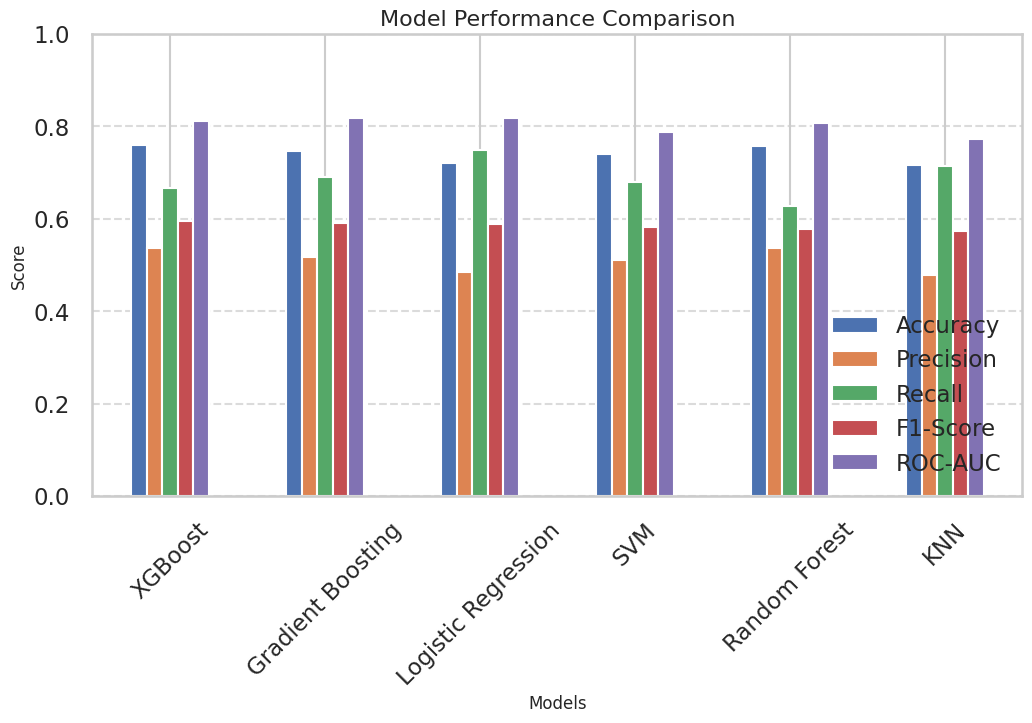

In [78]:
import matplotlib.pyplot as plt

# Plot comparison
comparison_df.plot(kind="bar", figsize=(12,6))
plt.title("Model Performance Comparison", fontsize=16)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.ylim(0,1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


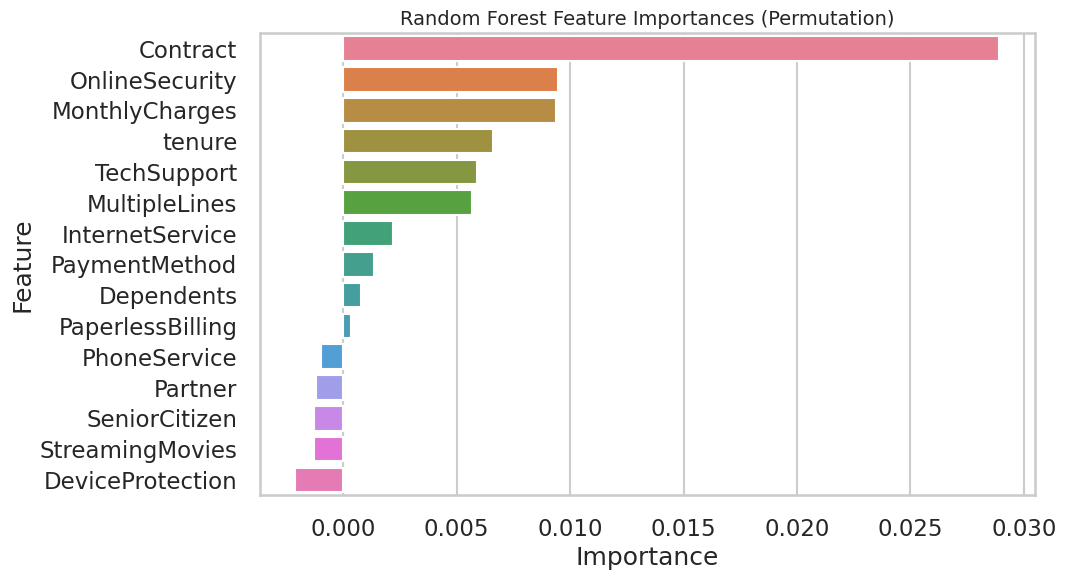

In [81]:
from sklearn.inspection import permutation_importance

# Use the fitted model from GridSearchCV
best_rf = grid_rf.best_estimator_

# Compute permutation importance
result = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=42)

# Store in dataframe
perm_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": result.importances_mean
}).sort_values(by="Importance", ascending=False)

# Show top 15
plt.figure(figsize=(10,6))
sns.barplot(data=perm_df.head(15), x="Importance", y="Feature", palette="husl")
plt.title("Random Forest Feature Importances (Permutation)", fontsize=14)
plt.show()


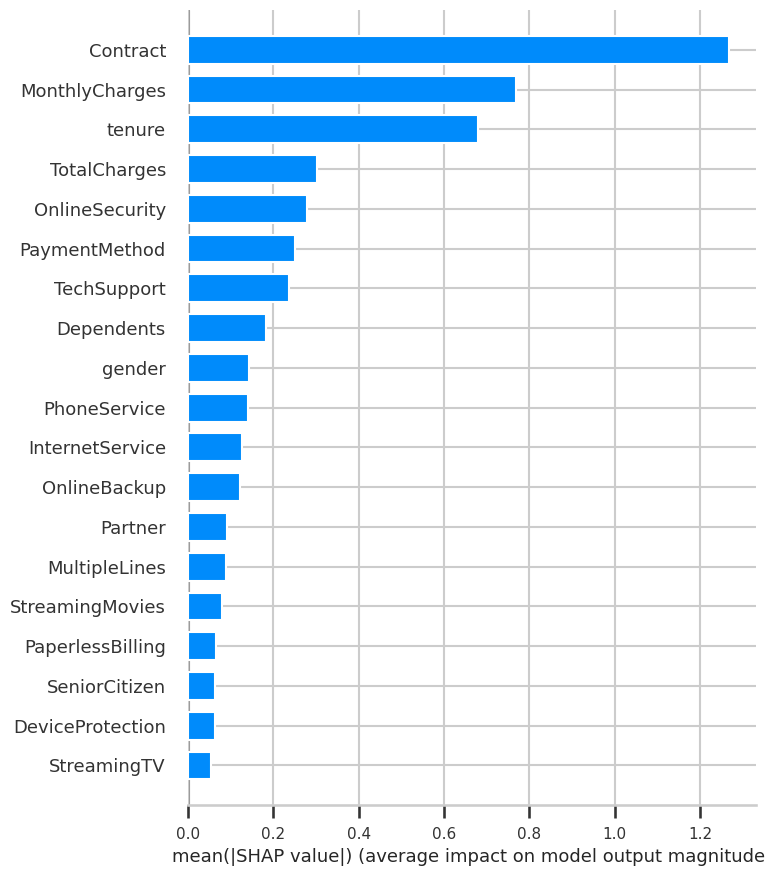

In [83]:
import shap

# Pick the best fitted model (example: XGBoost)
best_model = grid_xgb.best_estimator_   # you can swap with grid_rf.best_estimator_ etc.

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values for test set
shap_values = explainer.shap_values(X_test)

# 🔹 Global feature importance (summary bar)
shap.summary_plot(shap_values, X_test, plot_type="bar")




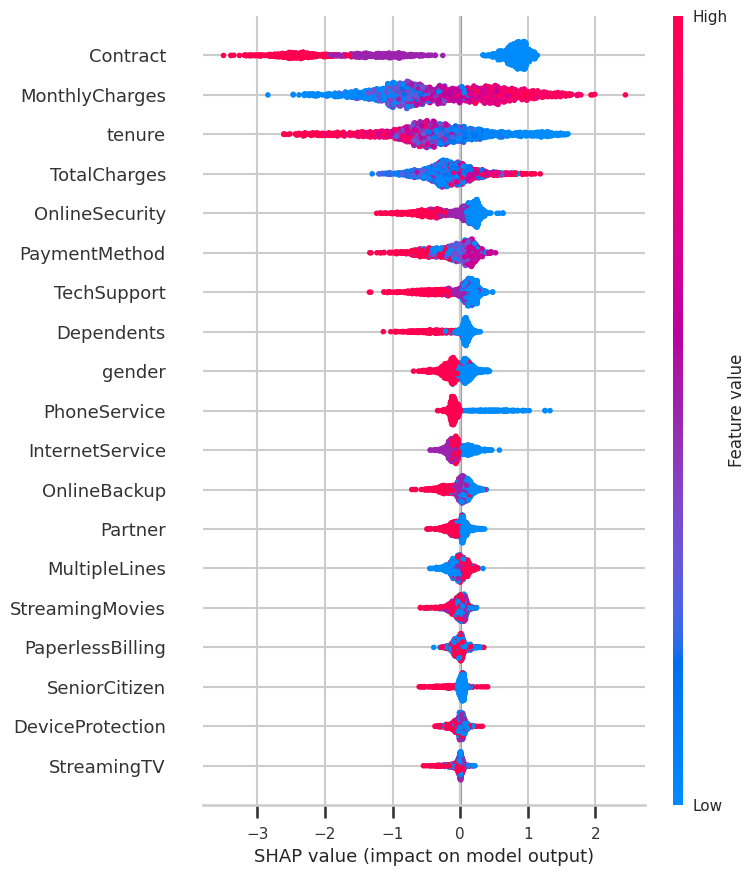

In [84]:
# 🔹 Beeswarm plot (how each feature impacts churn)
shap.summary_plot(shap_values, X_test)



In [85]:
# 🔹 Force plot for first test sample (local explanation)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

#Export data to csv file

In [86]:
import pandas as pd

# ✅ Use the best trained model (example: XGBoost, swap if needed)
best_model = grid_xgb.best_estimator_

# ✅ Predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# ✅ Build export dataframe
powerbi_data = X_test.copy()
powerbi_data["customerID"] = df.loc[X_test.index, "customerID"]   # bring back IDs
powerbi_data["Actual_Churn"] = y_test.values
powerbi_data["Predicted_Churn"] = y_pred
powerbi_data["Churn_Probability"] = y_proba

# ✅ Risk Segmentation
powerbi_data["Risk_Segment"] = pd.cut(
    powerbi_data["Churn_Probability"],
    bins=[0, 0.3, 0.7, 1.0],
    labels=["Low Risk", "Medium Risk", "High Risk"]
)

# ✅ Select only the most important features + outputs
selected_cols = [
    "customerID",
    "gender", "SeniorCitizen", "Partner", "Dependents",
    "tenure", "Contract", "PaymentMethod", "PaperlessBilling",
    "InternetService", "OnlineSecurity", "TechSupport",
    "MonthlyCharges", "TotalCharges",
    "Actual_Churn", "Predicted_Churn", "Churn_Probability", "Risk_Segment"
]

# Keep only available columns
final_cols = [col for col in selected_cols if col in powerbi_data.columns]
powerbi_export = powerbi_data[final_cols]

# ✅ Export to CSV
output_path = "powerbi_churn_results.csv"
powerbi_export.to_csv(output_path, index=False)

print(f"✅ Power BI dataset exported successfully: {output_path}")


✅ Power BI dataset exported successfully: powerbi_churn_results.csv
